In [ ]:
import torch
from data.dataset import GDMDataset
from torch.utils.data import DataLoader 

BATCH_SIZE = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = GDMDataset("../gas-distribution-datasets/synthetic/test/test90.pt", mode="test", split_ratio=0.2)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [2]:
X, y = next(iter(dataloader))
X = X.to(DEVICE)

## Models

### FNO

In [ ]:
from neuralop.models import FNO

fno_model = FNO(n_modes=(16, 16),
             in_channels=2,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2)
state_dict = torch.load("models/fno/weights.pth", map_location=DEVICE, weights_only=False)
fno_model.load_state_dict(state_dict)
fno_model = fno_model.to(DEVICE)
fno_model.eval();

### Diffusion

In [4]:
import torch
from models.diffusion.model import SimpleUnet
from models.diffusion.noise_scheduler import NoiseScheduler
from models.diffusion.sample import sample_timestep

diffusion_model = SimpleUnet(dims=(32, 64, 64), in_dim=3).to(DEVICE)
state_dict = torch.load("models/diffusion/weights.pt", map_location=DEVICE, weights_only=False)
diffusion_model.load_state_dict(state_dict)
scheduler = NoiseScheduler(T=100, beta_start=1e-4, beta_end=0.2, device=DEVICE)
diffusion_model = diffusion_model.to(DEVICE)
diffusion_model.eval();

In [5]:
import matplotlib.pyplot as plt

def sample_diffusion_model(X):
    batch_size, _, H, W = X.shape
    x_t = torch.randn((batch_size, 1, H, W), device=DEVICE)

    mask = X[:, 0:1, :, :]  # [batch_size, 1, H, W]
    vals = X[:, 1:2, :, :]  # [batch_size, 1, H, W]

    for t in reversed(range(scheduler.T)):
        t_tensor = torch.full((batch_size,), t, device=DEVICE, dtype=torch.long)
        with torch.no_grad():
            x_t = sample_timestep(x_t, mask, vals, t_tensor, diffusion_model, scheduler)

    return x_t

x_t = sample_diffusion_model(X)

### SoTA

In [14]:
from models.sota.kernel_dmv.wrapper import KernelDMV
from models.sota.dares.wrapper import Dares

# Load KDM+V
model_kdm = KernelDMV(x_range=[0,63], y_range=[0,63], cell_size=1, kernel_size=4)

# Load DARES
model_dares = Dares()

# Evaluation

### Synthetic test data

In [15]:
def prepare_sota_inputs(X):
    if BATCH_SIZE != 1:
        raise ValueError("BATCH_SIZE must be 1 for SOTA models evaluation.")

    mask = X[:, 0:1, :, :]  # [batch_size, 1, H, W]
    vals = X[:, 1:2, :, :]  # [batch_size, 1, H, W]

    mask_2d = mask[0][0]  # [H, W]
    y_coords, x_coords = torch.where(mask_2d == 1)
    positions = torch.stack([y_coords, x_coords], dim=1)
    measurements = vals[0][0][mask_2d.bool()]

    return positions.cpu(), measurements.cpu()

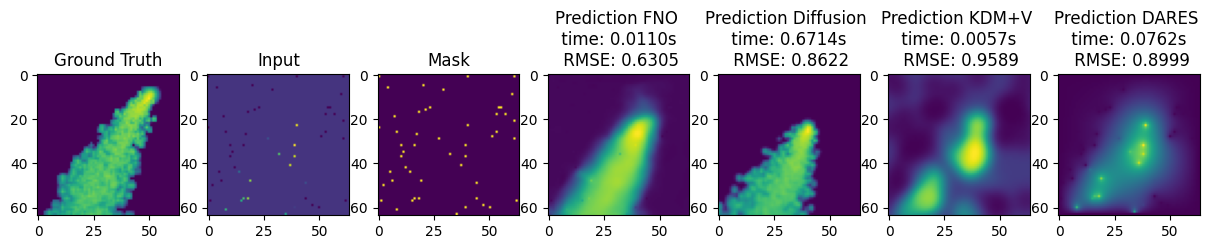

In [16]:
import time
import matplotlib.pyplot as plt

# loop until we find a sample with non-zero measurements
while True:
    X, y = next(iter(dataloader))
    X = X.to(DEVICE)
    mask = X[:, 0:1, :, :]  # [batch_size, 1, H, W]
    vals = X[:, 1:2, :, :]

    mask = X[:, 0:1, :, :]  # [batch_size, 1, H, W]
    vals = X[:, 1:2, :, :]

    if vals[mask.bool()].var() > 1e-3: 
        break

positions, measurements = prepare_sota_inputs(X)

rmses_fno = []
rmses_diffusion = []

plt.figure(figsize=(15, 7))
plt.subplot(1, 7, 1)
plt.title('Ground Truth')
plt.imshow(y[0].squeeze().cpu().numpy(), cmap='viridis')

plt.subplot(1, 7, 2)
plt.title('Input')
vals = X[:, 1, :, :].unsqueeze(1)
plt.imshow(vals[0].squeeze().cpu().detach().numpy(), cmap='viridis')

plt.subplot(1, 7, 3)
plt.title('Mask')
plt.imshow(X[0, 0, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')

plt.subplot(1, 7, 4)
start_time = time.time()
pred_fno = fno_model(X)
end_time = time.time()
plt.imshow(pred_fno[0].squeeze().cpu().detach().numpy(), cmap='viridis')
rmse_fno = torch.sqrt(torch.mean((pred_fno - y.to(DEVICE))**2))
rmses_fno.append(rmse_fno.item())
plt.title(f'Prediction FNO \n time: {end_time - start_time:.4f}s \n RMSE: {rmse_fno.item():.4f}');

plt.subplot(1, 7, 5)
start_time = time.time()
pred_diffusion = sample_diffusion_model(X)
end_time = time.time()
plt.imshow(pred_diffusion[0].squeeze().cpu().detach().numpy(), cmap='viridis')
rmse_diffusion = torch.sqrt(torch.mean((pred_diffusion - y.to(DEVICE))**2))
rmses_diffusion.append(rmse_diffusion.item())
plt.title(f'Prediction Diffusion \n time: {end_time - start_time:.4f}s \n RMSE: {rmse_diffusion.item():.4f}');

plt.subplot(1, 7, 6)
start_time = time.time()
model_kdm.set_measurements(positions, measurements)
pred_kdm = model_kdm.predict()
end_time = time.time()
plt.imshow(pred_kdm.cpu().detach().numpy(), cmap='viridis')
rmse_kdm = torch.sqrt(torch.mean((pred_kdm.to(DEVICE) - y[0].to(DEVICE))**2))
plt.title(f'Prediction KDM+V \n time: {end_time - start_time:.4f}s \n RMSE: {rmse_kdm.item():.4f}');

plt.subplot(1, 7, 7)
start_time = time.time()
model_dares.set_measurements(positions, measurements)
pred_dares = model_dares.predict()
end_time = time.time()
# pred_dares = torch.rot90(pred_dares, 0, dims=(0,1))
plt.imshow(pred_dares.cpu().detach().numpy(), cmap='viridis')
rmse_dares = torch.sqrt(torch.mean((pred_dares.to(DEVICE) - y[0].to(DEVICE))**2))
plt.title(f'Prediction DARES \n time: {end_time - start_time:.4f}s \n RMSE: {rmse_dares.item():.4f}');

### Tokyo Dataset

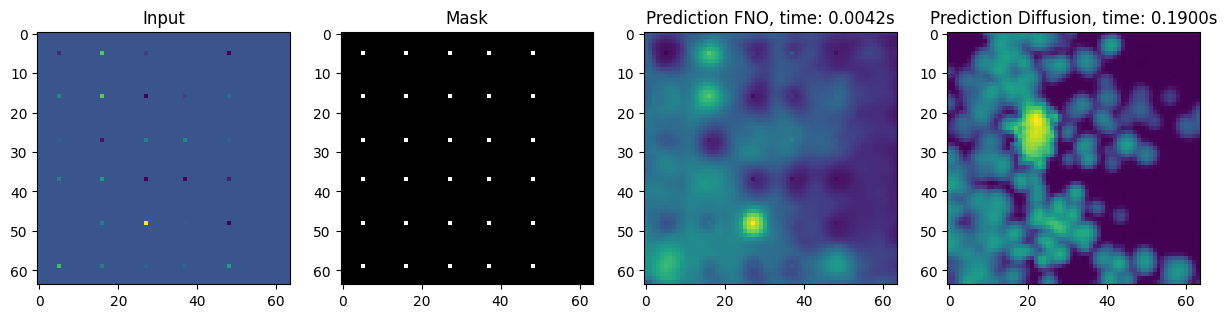

In [ ]:
from data.tokyo_dataset import TokyoDataset
tokyo_dataset = TokyoDataset(root="../gas-distribution-datasets/tokyo/02apr_log.pt")
tokyo_dataloader = DataLoader(tokyo_dataset, batch_size=1, shuffle=True)

X = next(iter(tokyo_dataloader))
X = X.to(DEVICE)
vals = X[:, 1, :, :].unsqueeze(1)
mask = X[:, 0, :, :].unsqueeze(1)

# z-score normalization
# Denormalize first
denormalized = vals * (3.3 - 0.0) + 0.0
# Then apply z-score
zscore_tensor = (denormalized - denormalized.mean()) / (denormalized.std() + 1e-8)
vals = zscore_tensor

plt.figure(figsize=(15, 5))
    
plt.subplot(1, 4, 1)
plt.title('Input')
plt.imshow(vals.squeeze().cpu().detach().numpy(), cmap='viridis')

plt.subplot(1, 4, 2)
plt.title('Mask')
plt.imshow(mask.squeeze().cpu().detach().numpy(), cmap='gray')

plt.subplot(1, 4, 3)
start_time = time.time()
pred_fno = fno_model(X)
end_time = time.time()
plt.title('Prediction FNO, time: {:.4f}s'.format(end_time - start_time))
plt.imshow(pred_fno.squeeze().cpu().detach().numpy(), cmap='viridis')

plt.subplot(1, 4, 4)
start_time = time.time()
pred_diffusion = sample_diffusion_model(X)
end_time = time.time()
plt.title('Prediction Diffusion, time: {:.4f}s'.format(end_time - start_time))
plt.imshow(pred_diffusion.squeeze().cpu().detach().numpy(), cmap='viridis')